In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd # 판다스 임포트.
import numpy as np
import matplotlib.pyplot as plt # 맷플롯립 임포트.
import seaborn as sns # 시본 임포트
import csv
import yfinance as yf

산점도 및 상관 계수

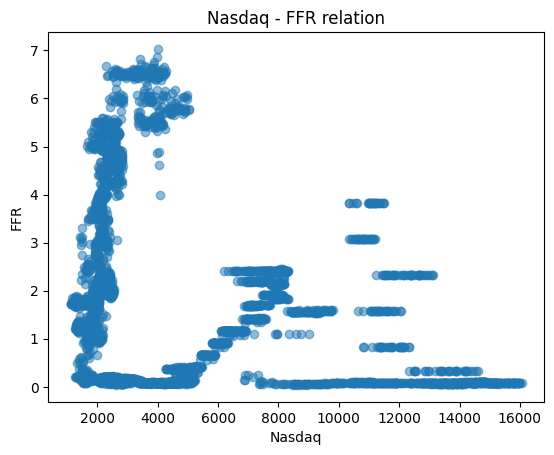

-0.23734546442162224


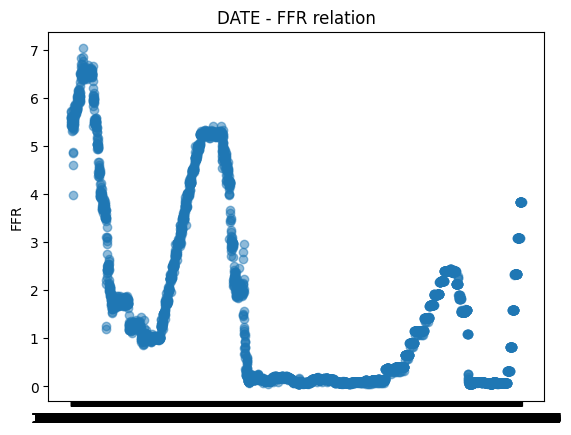

TypeError: ignored

In [23]:


data_x = pd.read_csv('/content/drive/MyDrive/SWEnglish/IXIC_daily.csv', sep = ',') #/content/drive/MyDrive/SWEnglish/IXIC_month.csv
data_x['Close'].shape

data_y = pd.read_csv('/content/drive/MyDrive/SWEnglish/FFR_data.csv', sep = ',') #/content/drive/MyDrive/SWEnglish/FFR_month.csv
data_y['DFF'].shape
##data['Date'].shape
##len(data[''])
##for row in data:
##  print(row)
data_z = pd.read_csv('/content/drive/MyDrive/SWEnglish/FFR_data.csv', sep = ',')
data_z['DATE'].shape

X = data_x.Close.values
Y = data_y.DFF.values
Z = data_z.DATE.values

plt.scatter(X, Y, alpha=0.5)
plt.title('Nasdaq - FFR relation') #두 지표의 상관 관계 분석 가능
plt.xlabel('Nasdaq')
plt.ylabel('FFR')
plt.show()

cov = (np.sum(X*Y) - len(X)*np.mean(X)*np.mean(Y)) / len(X)
corr = cov / (np.std(X) * np.std(Y)) ## corr 값이 0.3~0.7(뚜렷한 양적 선형관계), 0.7~1(강한 양적 선형관계)
print(corr)

plt.scatter(Z, Y, alpha=0.5)
plt.title('DATE - FFR relation') #두 지표의 상관 관계 분석 가능
#plt.xlabel('DATE')
plt.ylabel('FFR')
plt.show()

cov2 = (np.sum(Z*Y) - len(Z)*np.mean(Z)*np.mean(Y)) / len(X)
corr2 = cov2 / (np.std(Z) * np.std(Y)) ## corr 값이 0.3~0.7(뚜렷한 양적 선형관계), 0.7~1(강한 양적 선형관계)
corr2

피어슨 상관관계

In [18]:
df = pd.DataFrame(data_x)
df['FFR'] = data_y['DFF']

corr = df.corr(method = 'pearson')
corr

<ipython-input-18-ff32317fd450>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = 'pearson')


,Open,High,Low,Close,Adj Close,Volume,FFR
Open,1.000000,0.999928,0.999891,0.999803,0.999803,0.766087,-0.236839
High,0.999928,1.000000,0.999854,0.999891,0.999891,0.768098,-0.235614
Low,0.999891,0.999854,1.000000,0.999905,0.999905,0.763352,-0.238738
Close,0.999803,0.999891,0.999905,1.000000,1.000000,0.765706,-0.237345
Adj Close,0.999803,0.999891,0.999905,1.000000,1.000000,0.765706,-0.237345
Volume,0.766087,0.768098,0.763352,0.765706,0.765706,1.000000,-0.194855
FFR,-0.236839,-0.235614,-0.238738,-0.237345,-0.237345,-0.194855,1.000000


There are1510 obeservations in the training data
There are251 observations in the test data


<Axes: xlabel='Date'>

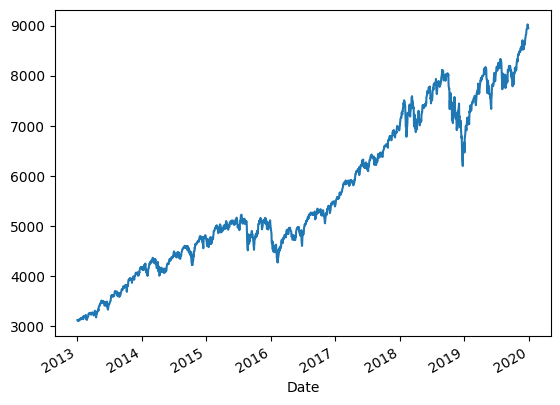

In [25]:
FFR = yf.download('^IXIC', start = '2013-01-01', end = '2019-12-31', progress = False)

all_data = FFR[['Adj Close', 'Open', 'High', 'Low', "Close", "Volume"]].round(2)
all_data.head(10)

print("There are" + str(all_data[:'2018'].shape[0])+" obeservations in the training data")
print("There are" + str(all_data['2019':].shape[0])+" observations in the test data")
all_data['Adj Close'].plot()

In [6]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
    time_steps: # of the input time steps
    for_periods: # of the output time steps
    '''
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

In [7]:
X_train, y_train, X_test = ts_train_test(all_data,5,2)
#X_train.shape[0],X_train.shape[1]
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")

print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1504 samples in the training data
There are 249 samples in the test data


In [26]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1504 samples in the training data
There are 249 samples in the test data


In [9]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
    time_steps: # of the input time steps
    for_periods: # of the output time steps
    '''
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [20]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5, 2)

In [15]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    # X_test를 LSTM 모델에 넣어서 예측
    LSTM_prediction = my_LSTM_model.predict(X_test)

    # 스케일러에 예측값 넣어 반환하기
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [16]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj.Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 3ms/step


(636553800000000.0, <Axes: xlabel='Date'>)

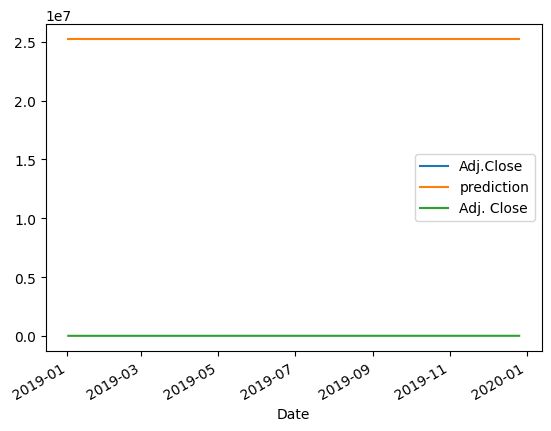

In [21]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)